In [2]:
# Emotion Detection   Hissiyotlarni aniqlash
#Dastlab, kerakli kutubxonalarni import qilib olamiz. 
#Bu kutubxonalar ma'lumotlarni qayta ishlash, model yaratish va baholash uchun kerak bo'ladi.


import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from keras import regularizers

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix , classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Ma'lumotlar joylashgan papkalarni va rasm o'lchamlarini aniqlab olamiz.

train_dir = "D:/fayl_ckachat/archive/test"
test_dir = "D:/fayl_ckachat/archive/train"

#original size of the image
img_height = 48
img_width = 48

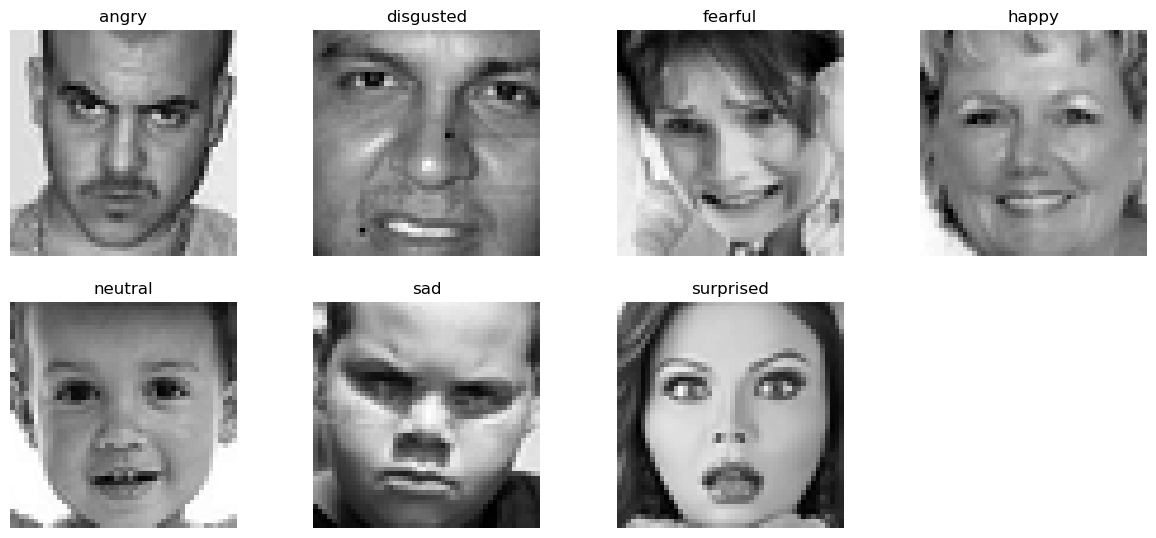

In [4]:
emotions=os.listdir(train_dir)  # train_dir popkasidagi barcha papka nomlarini(emotsiyalarini ifodalaydi) va  emotions ro'yxatiga yuklaydi masalan "happy", "Sad" popkalari bo'lishi mumkun
plt.figure(figsize=(15,10))     # bu qator plt.figure() funksiyasi yordamida yangi figura  yaratadi va figura o'lchamlari 15x10 dyuym qilib belgilaydi  
for i,emotion in enumerate(emotions,1):  # bu qator for siklini boshlaydi. "emotion" ro'yxatidagi har bir element "emotion" bo'yicha iteratsiya qiladi va siklning har bir iteratsiyasi uchun i o'zgaruvchisiga indeksni (1 dan boshlanadigan) qilib beradi beradi.
    folder=os.path.join(train_dir,emotion) # bu qator "train_dir" va "emotion" ni birlashtirib sinf (emotion) papkasining to'liq yulini hosil qilib beradi masalan: D:/fayl_ckachat/archive/test/Happy" bo'ladi.
    img_path=os.path.join(folder,os.listdir(folder)[6]) # Bu qator "folder" ichidagi fayllarni ro'yxatini oladi va ro'yxatning 6-elementini tanlaydi (indeks 0 dan boshlangani uchun bu 7-rasm bo'ladi). "folder" va rasm nomini birlashtirib, rasmning to'liq yo'lini hosil qiladi.  "os.path.join" yordamida fayl va papka yo'llarini birlashtirib, ularni operatsion tizimga mos ravishda to'g'ri formatda yaratish mumkin.
    img=plt.imread(img_path) #Bu qator rasmni o'qib, img o'zgaruvchisiga saqlaydi. plt.imread funksiyasi rasmni massiv sifatida qaytaradi.
    plt.subplot(3,4,i)     # Bu qator 3 qator va 4 ustundan iborat subplot yaratadi va i indeksiga mos joyni tanlaydi.
    plt.imshow(img,cmap='gray') # Bu qator img o'zgaruvchisidagi rasmni kulrang rang palitrasi bilan ko'rsatadi.
    plt.title(emotion) # Bu qator subplotga emotsiya nomi bilan sarlavha qo'shadi.
    plt.axis('off') # Bu qator subplot atrofidagi o'qlarni o'chiradi, shunda faqat rasm ko'rinadi.

In [4]:
# Data Augmentation   Ma'lumotlarni kengaytirish - bu modelni yaxshiroq umumlashtirishga yordam berish uchun 
# mavjud ma'lumotlar ustida turli xil o'zgartirishlar qo'llash orqali sun'iy ravishda ma'lumotlar to'plamini kengaytirish jarayoni. 
# Bu usul modellarni yanada barqaror va o'qitilgan ma'lumotlar asosida yaxshiroq ishlashiga yordam beradi.

train_datagen = ImageDataGenerator(#rotation_range = 180,    Bu obyekt trening ma'lumotlari uchun ma'lumotlarni kengaytirish va tayyorlash vazifasini bajaradi. 
                                         width_shift_range = 0.1,  #  Rasmni gorizontal bo'ylab 0.1 foizgacha o'zgartirish (siljitish).
                                         height_shift_range = 0.1, # Rasmni vertikal bo'ylab 0.1 foizgacha o'zgartirish (siljitish).
                                         horizontal_flip = True,  # Rasmni gorizontal bo'ylab akslantirish (flip).
                                         rescale = 1./255,  # Barcha piksel qiymatlarini 0 va 1 oralig'iga normallashtirish (255 ga bo'lish).
                                         #zoom_range = 0.2,
                                         validation_split = 0.2  # Ma'lumotlarni 80% trening uchun va 20% validatsiya uchun ajratish.
                                        )

        # Bu obyekt validatsiya ma'lumotlarini tayyorlash uchun ishlatiladi. Unda kengaytirish parametrlar yo'q, faqat rescaling 
        # (normallashtirish) amalga oshiriladi va ma'lumotlarni 20% validatsiya uchun ajratish iborat
validation_datagen = ImageDataGenerator(rescale = 1./255,  # Ma'lumotlarni 80% trening uchun va 20% validatsiya uchun ajratish.
                                         validation_split = 0.2) 

# Bu obyekt test ma'lumotlarini tayyorlash uchun ishlatiladi. U ham kengaytirish parametrlar yo'q, faqat rescaling 
#(normallashtirish) amalga oshiriladi va ma'lumotlarni 50% validatsiya uchun ajratish mavjud.
test_datagen = ImageDataGenerator(rescale = 1./255, # Barcha piksel qiymatlarini 0 va 1 oralig'iga normallashtirish (255 ga bo'lish).
                                         validation_split = 0.5) #  Ma'lumotlarni teng yarmiga ajratish (50% test uchun, 50% validatsiya uchun). 

In [5]:
# Applying data augmentation to the images as we read them from their respectivve directories
# "train_datagen" Bu ImageDataGenerator obyektidir, u trening ma'lumotlarini o'zgartirish uchun parametrlarni o'z ichiga oladi.
# "flow_from_directory" : Ushbu funksiya berilgan katalogdan rasmlarni o'qiydi va ularni real vaqtda o'zgartiradi.
train_generator = train_datagen.flow_from_directory(directory = train_dir,   # Rasm ma'lumotlarining joylashgan katalogi (masalan, "D:/fayl_ckachat/archive/test").
                                                    target_size = (img_height,img_width), #Har bir rasm o'lchamini (balandlik va kenglik) belgilaydi (bu holda, 48x48 piksel).
                                                    batch_size = 64, # Har bir iteratsiyada modelga yuboriladigan rasm soni.
                                                    color_mode = "grayscale", # Rasmlarni kul rangda o'qiydi (kul rang tasvirlar)
                                                    class_mode = "categorical",  # Maqsadli o'zgaruvchilarni kategorik formatda belgilaydi (rasmlar turli toifalarga bo'lingan).
                                                    subset = "training"  # Ma'lumotlarni trening uchun ajratadi (validation_split = 0.2 bo'lgani uchun, trening uchun 80% ma'lumot ajratiladi).
                                                   )

# validation_datagen: Bu ImageDataGenerator obyektidir, u validatsiya ma'lumotlarini tayyorlash uchun parametrlarni o'z ichiga oladi.
validation_generator = validation_datagen.flow_from_directory( directory = train_dir,  # Rasm ma'lumotlarining joylashgan katalogi (masalan, "D:/fayl_ckachat/archive/test").
                                                              target_size = (img_height,img_width), # Har bir rasm o'lchamini (balandlik va kenglik) belgilaydi.
                                                              batch_size = 64,  # Har bir iteratsiyada modelga yuboriladigan rasm soni.
                                                              color_mode = "grayscale", # Rasmlarni kul rangda o'qiydi.
                                                              class_mode = "categorical", # Maqsadli o'zgaruvchilarni kategorik formatda belgilaydi.
                                                              subset = "validation" # Ma'lumotlarni validatsiya uchun ajratadi (validation_split = 0.2 bo'lgani uchun, validatsiya uchun 20% ma'lumot ajratiladi).
                                                             )

# test_datagen: Bu ImageDataGenerator obyektidir, u test ma'lumotlarini tayyorlash uchun parametrlarni o'z ichiga oladi.

test_generator = test_datagen.flow_from_directory(directory = test_dir, # Rasm ma'lumotlarining joylashgan katalogi (masalan, "D:/fayl_ckachat/archive/train").
                                                        target_size = (img_height,img_width), # : Har bir rasm o'lchamini (balandlik va kenglik) belgilaydi.
                                                        batch_size = 64, # Har bir iteratsiyada modelga yuboriladigan rasm soni. 
                                                        shuffle  = False ,  # Test ma'lumotlarini aralashtirmaslik uchun (ma'lumotlar ketma-ketligini saqlab qoladi).
                                                        color_mode = "grayscale", # Rasmlarni kul rangda o'qiydi.
                                                        class_mode = "categorical", # Maqsadli o'zgaruvchilarni kategorik formatda belgilaydi.
                                                        seed = 12 # Tasodifiylikni boshqarish uchun urug' (seed) qiymati, shunda natijalar qayta ishlab chiqarilishi mumkin.
                                                             )

Found 5746 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.


In [6]:
model= Sequential() # Sequential: Bu Kerasda oddiy model yaratish usuli bo'lib, qatlamlarni ketma-ket joylashtirish imkonini beradi.
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1))) # Bu qatlam 32 ta 3x3 o'lchamdagi filtrlarni qo'llaydi.
# Filtrlarni qo'llaganda chiziqlarning o'lchamini saqlab qoladi.  
# padding='same': Filtrlarni qo'llaganda chiziqlarning o'lchamini saqlab qoladi.
# activation='relu': Aktivatsiya funksiyasi sifatida ReLU (Rectified Linear Unit) ishlatiladi, bu nol va musbat qiymatlar orasidagi negativ qiymatlarni nolga aylantiradi.
# input_shape=(48, 48, 1): Kiritish tasvirining o'lchami 48x48 piksel va 1 kanaldan (kul rang) iborat.
model.add(Conv2D(64,(3,3), padding='same', activation='relu' )) # Conv2D(64, (3, 3)): Bu qatlam 64 ta 3x3 o'lchamdagi filtrlarni qo'llaydi.
# padding='same' va activation='relu': Oldingi qatlam kabi.

model.add(BatchNormalization()) # BatchNormalization: Har bir mini-batch uchun ma'lumotlarni normallashtiradi, bu tarmoqni tezroq va barqarorroq o'qitishga yordam beradi.
model.add(MaxPool2D(pool_size=(2, 2))) # MaxPool2D(pool_size=(2, 2)): Tasvirni 2x2 o'lchamdagi bloklar bo'yicha kamaytiradi, bu ma'lumotlarni siqish va muhim xususiyatlarni saqlashga yordam beradi.
model.add(Dropout(0.25)) # Dropout(0.25): O'qitish paytida 25% neyronlarni tasodifiy o'chirib turadi, bu overfitting (haddan tashqari moslashuv) ni oldini olishga yordam beradi.

model.add(Conv2D(128,(5,5), padding='same', activation='relu')) # Conv2D(128, (5, 5)): Bu qatlam 128 ta 5x5 o'lchamdagi filtrlarni qo'llaydi.
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))) #  Bu qatlam 512 ta 3x3 o'lchamdagi filtrlarni qo'llaydi.  "kernel_regularizer=regularizers.l2(0.01)": L2 regularizatsiyasi qo'shiladi, bu overfitting ni kamaytirishga yordam beradi.
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) # Flatten: Konvolyutsion qatlamlarning chiqishini bir o'lchamli vektor sifatida tekislaydi.
model.add(Dense(256,activation = 'relu'))  #  256 ta neyronli to'liq bog'langan qatlam.
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu')) # 512 ta neyronli to'liq bog'langan qatlam.
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax')) # Dense(7): 7 ta neyronli to'liq bog'langan qatlam, chunki bizda 7 ta sinf (emotsiyalar) bor 
# activation='softmax': Softmax aktivatsiya funksiyasi, bu ehtimolliklarni hisoblash uchun ishlatiladi (har bir sinf uchun).

model.compile(
    optimizer = Adam(learning_rate=0.0001),  #  Adam optimizatori o'rnatiladi, o'qitish jarayonini boshqarish uchun ishlatiladi.
    loss='categorical_crossentropy',  # Yo'qotish funksiyasi sifatida kategorik kross-entropiya ishlatiladi, bu ko'p sinfli tasniflash vazifalari uchun mos.
    metrics=['accuracy'] # Modelning aniqlik (accuracy) ko'rsatkichini kuzatish uchun
  )

In [7]:
# model.summary() funksiyasi modelning tuzilishini ko'rsatadi, ya'ni qatlamlarning turlari, har bir qatlamdagi parametrlari soni va umumiy parametrlar
# soni kabi ma'lumotlarni beradi. Bu, odatda, modelni tekshirish va tahlil qilish uchun juda foydali. 
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,496,903 (17.15 MB)

 Trainable params: 4,492,935 (17.14 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [10]:
# Yuqoridagi kod bo'yicha, modelni train_generator ma'lumotlari orqali o'qitish uchun fit funksiyasini ishga tushirish bilan bog'liq 
# bo'lgan ma'lumotlar kiritilgan. epochs - o'qitishning qancha marta amalga oshirilishini, batch_size esa har bir o'qituvchi lotining 
#nechta tasvirdan iborat bo'lishini belgilaydi.
epochs = 60
batch_size = 64
# model.fit() funktsiyasi orqali, modelni o'qitish jarayonini boshlayapmiz. train_generator va validation_generator orqali ta'minlangan
# ma'lumotlar bilan modelni o'qitamiz. epochs parametri yordamida o'qitish jarayonini necha marta amalga oshirishni belgilaymiz. batch_size
# parametri esa har bir o'qituvchi lotining nechta tasvirdan iborat bo'lishini aniqlaydi
history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator)

Epoch 1/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.1614 - loss: 9.9129 - val_accuracy: 0.2472 - val_loss: 8.9779
Epoch 2/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 80s 890ms/step - accuracy: 0.1980 - loss: 9.4356 - val_accuracy: 0.1159 - val_loss: 8.9983
Epoch 3/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 78s 869ms/step - accuracy: 0.2098 - loss: 9.1287 - val_accuracy: 0.1739 - val_loss: 9.0079
Epoch 4/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 71s 785ms/step - accuracy: 0.2213 - loss: 8.8938 - val_accuracy: 0.2465 - val_loss: 9.0069
Epoch 5/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 72s 786ms/step - accuracy: 0.2103 - loss: 8.6660 - val_accuracy: 0.2270 - val_loss: 8.6155
Epoch 6/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 74s 813ms/step - accuracy: 0.2356 - loss: 8.3591 - val_accuracy: 0.2472 - val_loss: 8.3750
Epoch 7/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 77s 859ms/step - accuracy: 0.2428 - loss: 8.1200 - val_accuracy: 0.2528 - val_loss: 7.9230
Epoch 8/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 66s 731ms/step - accuracy: 0.2317 - loss: 7.9018 - val_accura

In [11]:
# Siz model.save() funksiyasi orqali modelni model_optimal.h5 nomli faylga saqladingiz. Bu fayl TensorFlow yoki Keras orqali saqlangan vaqtincha
# modelni saqlash formatidir.
model.save('model_optimal.h5')


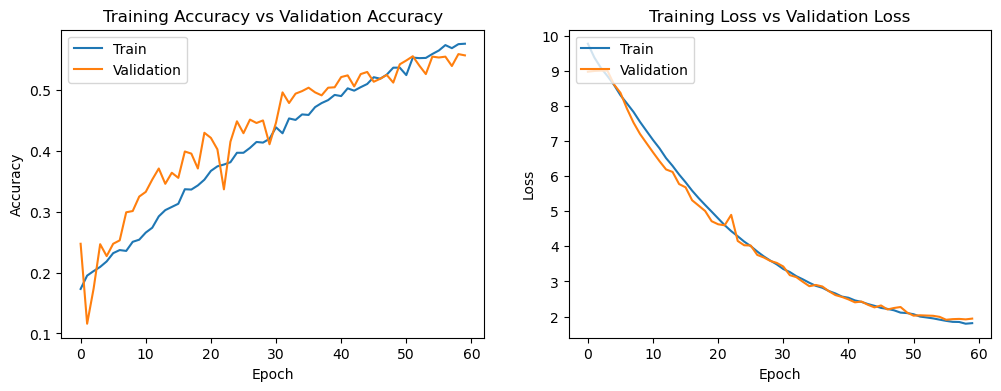

In [12]:
fig , ax = plt.subplots(1,2) #  Figura va o'qishlarni ko'rsatish uchun matplotlib kutubxonasi ishlatiladi
train_acc = history.history['accuracy']  # O'qitilgan dastlabki ma'lumotlarining ishonchliligini o'qish
train_loss = history.history['loss'] # O'qitilgan dastlabki ma'lumotlarining xatolarini o'qish
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy']) # O'qitilgan ma'lumotlarning ishonchlilik hisobotini plot qilish
ax[0].plot(history.history['val_accuracy']) # # O'qitilgan ma'lumotlarning validatsiya ishonchlilik hisobotini plot qilish
ax[0].set_title('Training Accuracy vs Validation Accuracy') # Sarlavha
ax[0].set_ylabel('Accuracy') # Y o'qi sarlavhasi
ax[0].set_xlabel('Epoch') # X o'qi sarlavhasi
ax[0].legend(['Train', 'Validation'], loc='upper left') # Yo'nalishlar

ax[1].plot(history.history['loss']) # O'qitilgan ma'lumotlarning xatolarini plot qilish
ax[1].plot(history.history['val_loss']) # O'qitilgan ma'lumotlarning validatsiya xatolarini plot qilish
ax[1].set_title('Training Loss vs Validation Loss') # Sarlavha
ax[1].set_ylabel('Loss')  # Y o'qi sarlavhasi
ax[1].set_xlabel('Epoch') # X o'qi sarlavhasi
ax[1].legend(['Train', 'Validation'], loc='upper left') # Yo'nalishlar

# Plotni ko'rsatish
plt.show()

In [14]:
model.evaluate(test_generator) # Bu qator test datalari ustida o'qitilgan modelni baholaydi.   orqali test datalari yuklanadi va modelning barcha metric'lari (masalan, ishonchlilik, xato, va boshqa metrikalar) hisoblanadi.
preds = model.predict(test_generator) # Bu qator test datalari ustida modelning prognazlarini hisoblaydi. test_generator orqali test datalari yuklanadi va model prognazlarini qaytaradi.
y_preds = np.argmax(preds , axis = 1 ) # Bu qator modelning prognazlarining kategoriyalarini aniqlab chiqaradi. preds degan o'zgaruvchidan modelning prognazlarini oladi va axis=1 bilan argmax funksiyasi yordamida eng yuqori qiymatga ega bo'lgan indekslarni aniqlaydi, ya'ni kategoriyalarni.
y_test = np.array(test_generator.labels) #Bu qator test datalari ustida haqiqiy etiketlarni olish uchun ishlatiladi. test_generator.labels orqali test datalari yuklanadi va ulardagi haqiqiy etiketlar np.array bilan arrayga o'tkaziladi.

449/449 ━━━━━━━━━━━━━━━━━━━━ 201s 448ms/step - accuracy: 0.5011 - loss: 2.0234
449/449 ━━━━━━━━━━━━━━━━━━━━ 83s 184ms/step


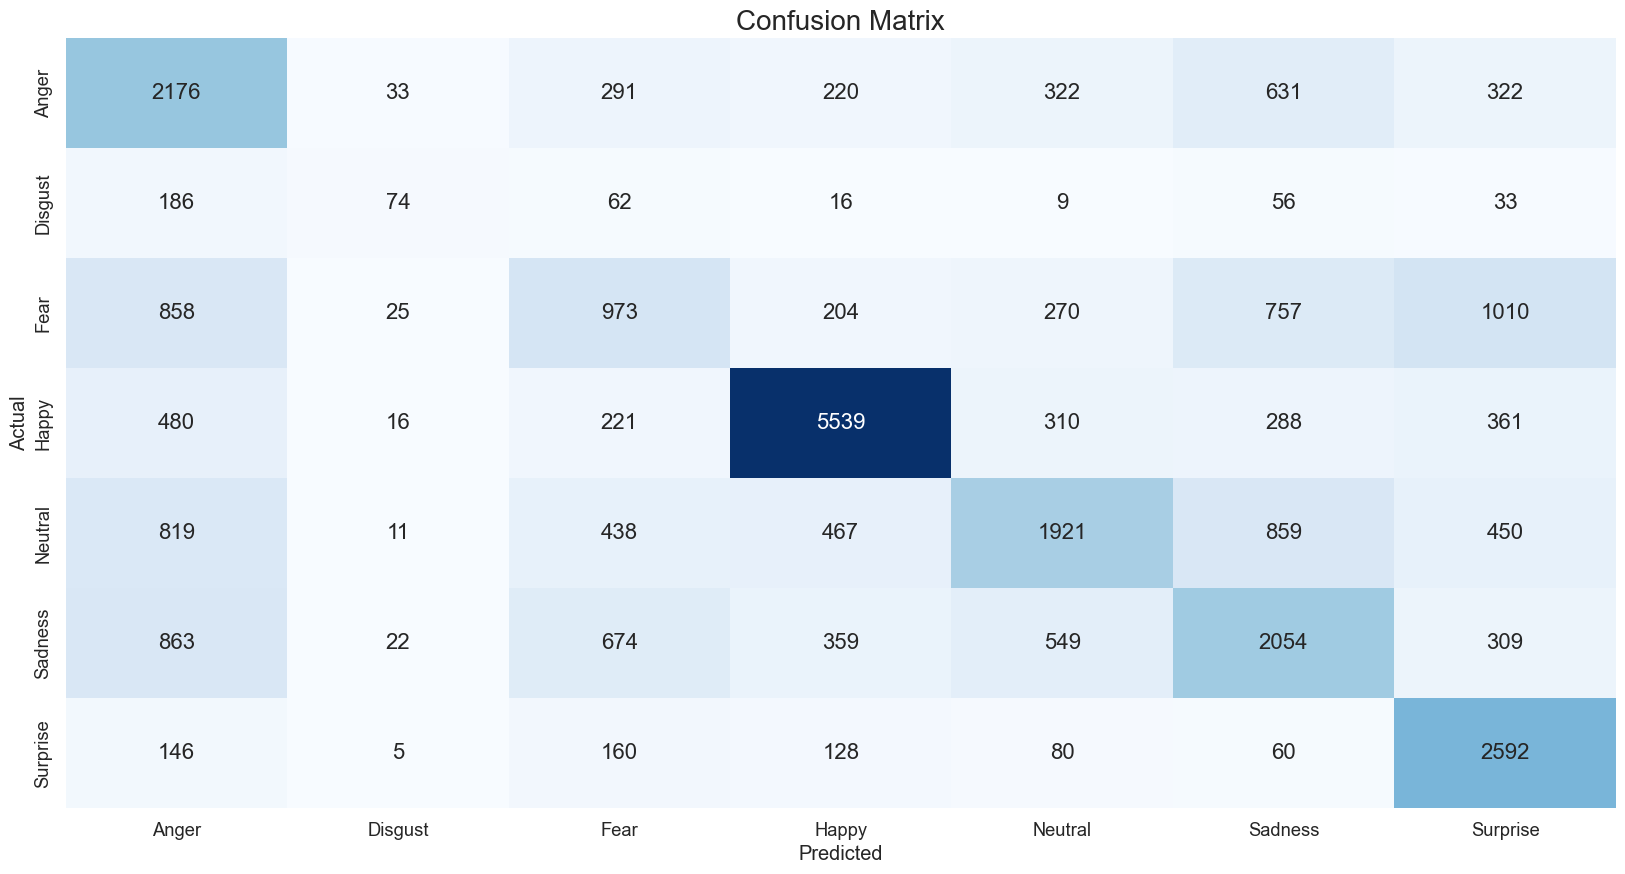

In [16]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"] # CLASS_LABELS: Bu ro'yhat, confusion matrixda qo'llaniladigan sinflarni (klasslar) ifodalaydi.

cm_data = confusion_matrix(y_test , y_preds) # Bu qator confusion matrixni hisoblaydi.  confusion_matrix funksiyasi y_test (haqiqiy etiketlar) va y_preds (prognazlangan etiketlar) orqali har bir sinfdagi to'g'ri va noto'g'ri prognazlangan natijalarni hisoblaydi.
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS) #  Bu qator, confusion matrixni DataFramega o'zlashtiradi. U sinflarni (klasslar) ustida va oldindan o'zlashtirilgan diagnallar bilan bog'liq.
cm.index.name = 'Actual' # : Bu qatorlar, indeks va ustun nomlarini o'zlashtirilgan confusion matrixga qo'shadilar.
cm.columns.name = 'Predicted' 
plt.figure(figsize = (20,10)) #  Bu qator, confusion matrixning o'lchamini (hajmini) aniqlayd
plt.title('Confusion Matrix', fontsize = 20) # Bu qator, confusion matrix sarlavhasini (nomini) aniqlaydi.
sns.set(font_scale=1.2) # Bu qator, seaborn stilini sozlash uchun ishlatiladi.
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g') # Bu qator, confusion matrixni seaborn kutubxonasi yordamida
# chizadi. annot=True orqali qiymatlar annotatsiyalar bilan ko'rsatiladi. cmap orqali ranglarni aniqlaydi.

In [17]:
print(classification_report(y_test, y_preds))  # y_test: haqiqiy etiketlarni o'z ichiga olgan array. y_preds: prognazlangan etiketlarni o'z ichiga olgan array.
# Bu koddagi classification_report funksiyasi, barcha sinflar uchun precision, recall, F1-score, va har bir sinfdagi obyektlar soni (support)ni ko'rsatadi.
# Natijalar qaytadi uchun, terminalda yoki kod yozuvchi muhitida ko'rsatiladi

              precision    recall  f1-score   support

           0       0.39      0.54      0.46      3995
           1       0.40      0.17      0.24       436
           2       0.35      0.24      0.28      4097
           3       0.80      0.77      0.78      7215
           4       0.56      0.39      0.46      4965
           5       0.44      0.43      0.43      4830
           6       0.51      0.82      0.63      3171

    accuracy                           0.53     28709
   macro avg       0.49      0.48      0.47     28709
weighted avg       0.54      0.53      0.52     28709



ROC AUC score: 0.8687286454831993


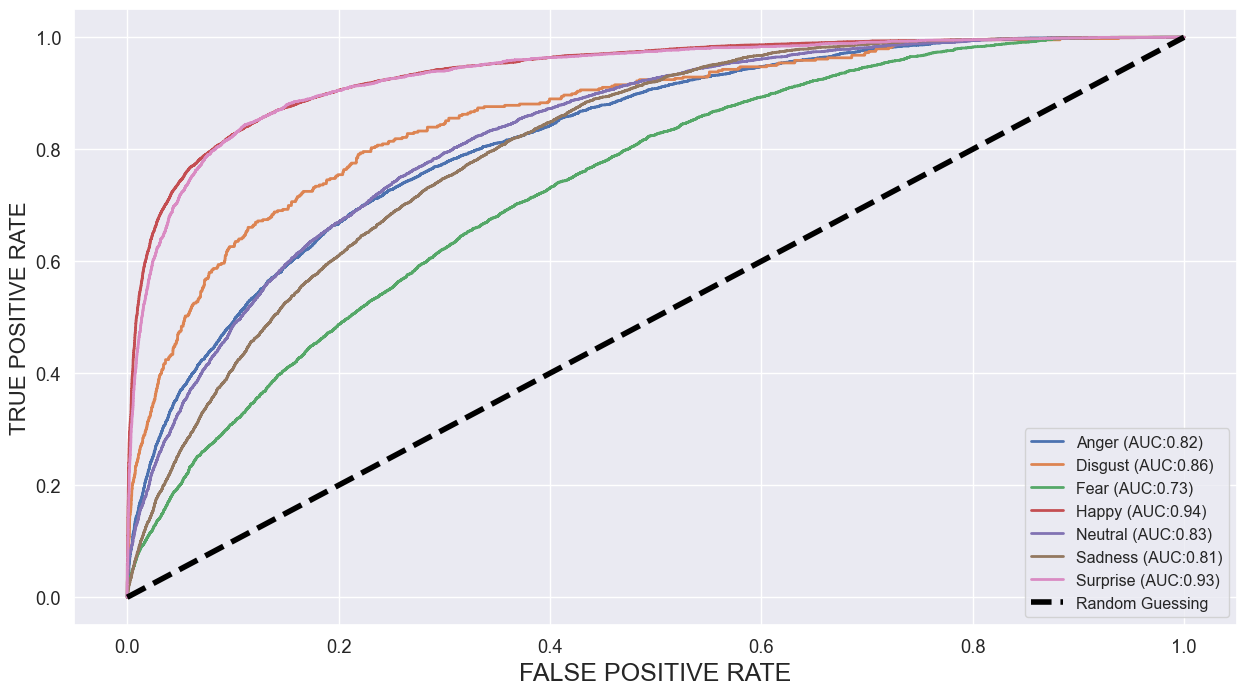

In [18]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8)) # # Grafik o'lchamini belgilab oladi

# # Ko'rsatkichlarni baholash uchun ROC karnayi chizish
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer() # # LabelBinarizer obyekti yaratiladi
    lb.fit(y_test) # Test ma'lumotlari bilan LabelBinarizer obyekti uchun uygun bo'lsa yig'iladi
    y_test = lb.transform(y_test) #  Test ma'lumotlarini binar ko'rinishga o'tkazadi
    for (idx, c_label) in enumerate(CLASS_LABELS): #  # Barcha sinflarni indeksi va nomi bo'yicha iteratsiya
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx]) # FPR va TPR hisoblanadi
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr))) # ROC karnayi chiziladi
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing') #     # Tasodifiy taxminlash liniyasi
    return roc_auc_score(y_test, y_pred, average=average)

    # ROC AUC bahosini hisoblash va ekranga chiqarish
print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18) # X o'qini "FALSE POSITIVE RATE" deb nomlaydi va 18 ekranning o'lchamini sozlash uchun xizmat qiladi.
plt.ylabel('TRUE POSITIVE RATE', fontsize=16) #  Y o'qini "TRUE POSITIVE RATE" deb nomlaydi va 16 ekranning o'lchamini sozlash uchun xizmat qiladi.
plt.legend(fontsize = 11.5) # Grafik legendasining o'lchamini 11.5 ekranning o'lchamiga sozlash uchun xizmat qiladi.
plt.show()  # Barcha sozlamalar amalga oshirilgan plotni ekranga chiqaradi.

In [19]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))
# Ushbu qator, ROC-AUC skorini hisoblash uchun bir nechta boshqa klassifayorlar (kerakli bo'lsa)ning natijalari bilan biriktirilgan to'g'ri javoblarni 
#(to_categorical(y_test)) o'rgatadi. Kiritilgan preds degan model natijalari bilan ta'minlaydi. Natijani "ROC-AUC Score =" deb nomlangan matnga qo'shib
# ekranga chiqaradi.

ROC-AUC Score  =  0.8461647458586717


In [1]:
import nbformat

# Faylni ochish
notebook_path = 'C:/Users/Lenovo/Desktop/django-faceid/jupeter.ipynb'
with open(notebook_path) as f:
    nb = nbformat.read(f, as_version=4)

# Birinchi kod hujayrasini olish
first_code_cell = nb['cells'][0]['source']

# Birinchi kod hujayrasini bajaring va natijalarni oling
exec(first_code_cell)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Lenovo/Desktop/django-faceid/main.html'